In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import re
from sklearn.ensemble import RandomForestClassifier

from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.metrics import classification_report, confusion_matrix

import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn import svm
from sklearn.dummy import DummyClassifier


from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_val_score

from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_predict
from sklearn.metrics import r2_score 


from sklearn.neural_network import MLPClassifier
from collections import Counter

from sklearn.ensemble import AdaBoostClassifier
from imblearn.over_sampling import SVMSMOTE

import imblearn
from imblearn.over_sampling import SMOTE


In [2]:
# data preprocessing

train = pd.read_csv("recipe_train.csv")
test = pd.read_csv("recipe_test.csv")


train_steps = pd.read_csv("train_steps_doc2vec50.csv", header=None)
train_name = pd.read_csv("train_name_doc2vec50.csv", header=None)
train_ingr = pd.read_csv("train_ingr_doc2vec100.csv", header=None)




In [3]:
# feature engineering and selection

full_data = [train, test]

for dataset in full_data:
    dataset['n_steps_ingred'] = dataset['n_steps'] + dataset['n_ingredients']
    

# a function that extracts length of time from the description 'steps'
def getTime(df):
    times = []
    pattern = r'\d+-\d+ minute'
    hours = r'\d+-\d+ hour'
    seconds = r'\d+-\d+ second'


    for step in df['steps']:
    
        time = 0
        for i in re.findall(r'\d+ minute', step):
            time += int(i.split()[0])
        for i in re.findall(r'\d+ second', step):
            time += int(i.split()[0])/60
        for i in re.findall(r'\d+ hour', step):
            time += int(i.split()[0])*60
        for i in re.findall(pattern, step):
            time += (sum([int(x) for x in i.split()[0].split('-')])/2)
        for i in re.findall(hours, step):
            time += (sum([int(x) for x in i.split()[0].split('-')])/2)*60
        for i in re.findall(seconds, step):
            time += (sum([int(x) for x in i.split()[0].split('-')])/2)/60
        times.append(time)
    df['times'] = times
    return df 

train = getTime(train)
test = getTime(test)

new_data = []

for i in range(len(train_name)):
    a = np.array(train_name.iloc[i])
    b = np.array(train_ingr.iloc[i])
    c = np.array(train_steps.iloc[i])
    d = np.array(train.iloc[i][['times', 'n_steps', 'n_ingredients', 'duration_label']])
    new = np.hstack((c,d))
    new_data.append(new)
    
train_df = pd.DataFrame(new_data)


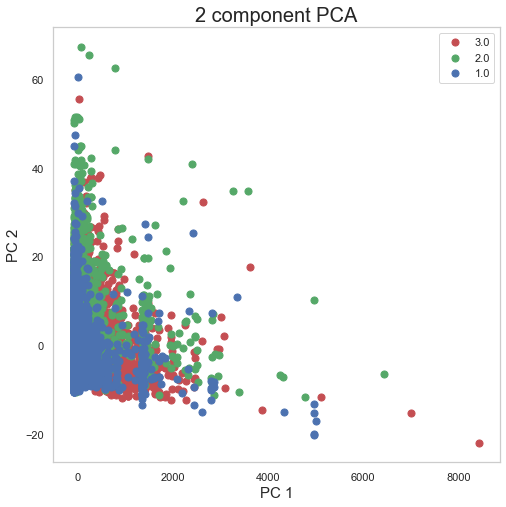

In [6]:
# cluster visualization using PCA

from sklearn.decomposition import PCA


x = train_df.values[:,:-1]
y = train_df.values[:,-1]
y = y.astype('int')

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])

finalDf = pd.concat([principalDf, train['duration_label']], axis = 1)


fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC 1', fontsize = 15)
ax.set_ylabel('PC 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [3.0,2.0,1.0]
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['duration_label'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'PC1'], finalDf.loc[indicesToKeep, 'PC2'], c = color, s = 50)
ax.legend(targets)
ax.grid()

plt.savefig("PCA visuallization")

In [ ]:
# tuning parameters for decision tree

from sklearn.metrics import roc_curve, auc

from imblearn.under_sampling import TomekLinks 

def get_score(model, df):
    X = df.values[:,:-1]
    y = df.values[:,-1]
    y = y.astype('int')

    y_pred = cross_val_predict(model, X, y, cv=10)
    conf_mat = confusion_matrix(y, y_pred)
    accuracy = accuracy_score(y, y_pred)

    return accuracy 

max_depths = np.linspace(1, 32, 32, endpoint=True)
 
scores = []
for max_depth in max_depths:
    scores.append(get_score(DecisionTreeClassifier(max_depth = max_depth), train_df))
    
plt.plot(max_depths, scores)
plt.xlabel("max_depths")
plt.ylabel("scores")
plt.show()


# tune parameters for mlpc using gridsearch  

mlp_gs = MLPClassifier(max_iter=100)
parameter_space = {
    'hidden_layer_sizes': [(10,30,10),(20,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

X = train_df.values[:,:-1]
y = train_df.values[:,-1]
y = y.astype('int')

from sklearn.model_selection import GridSearchCV
clf = GridSearchCV(mlp_gs, parameter_space, n_jobs=-1, cv=5)
clf.fit(X, y) # X is train samples and y is the corresponding labels

print('Best parameters found:\n', clf.best_params_)

Mean Accuracy: 0.506
Mean Accuracy: 0.753
Mean Accuracy: 0.720
Mean Accuracy: 0.771
Mean Accuracy: 0.765
Mean Accuracy: 0.713
Mean Accuracy: 0.782


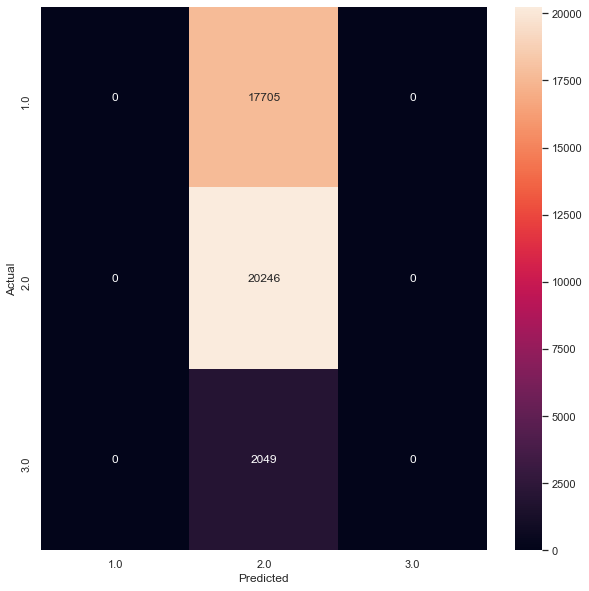

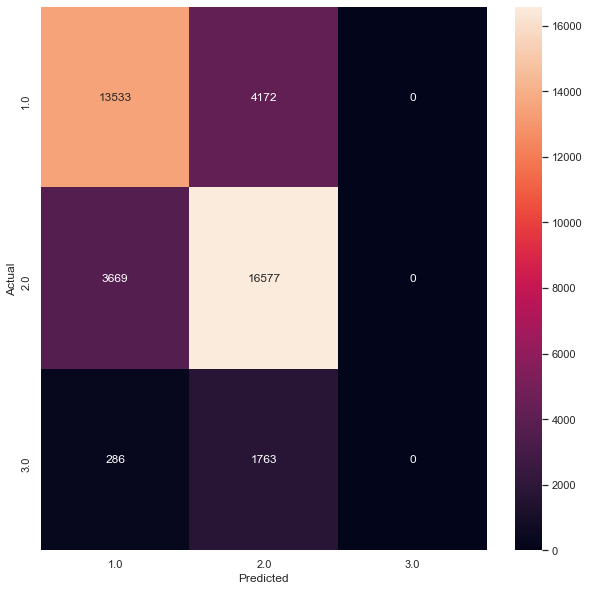

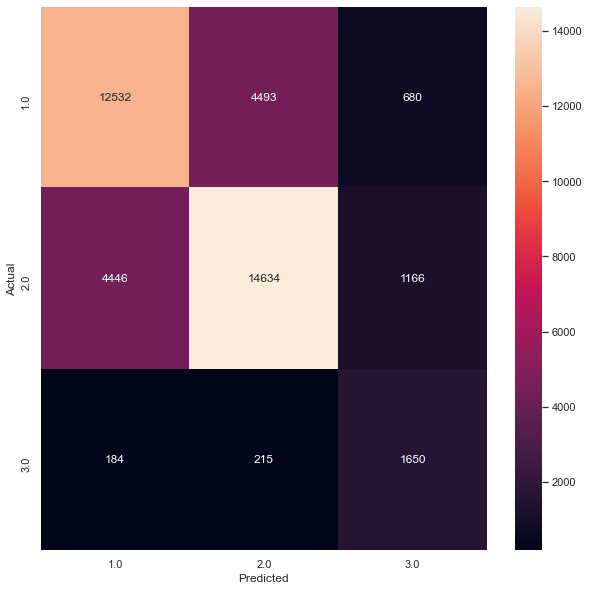

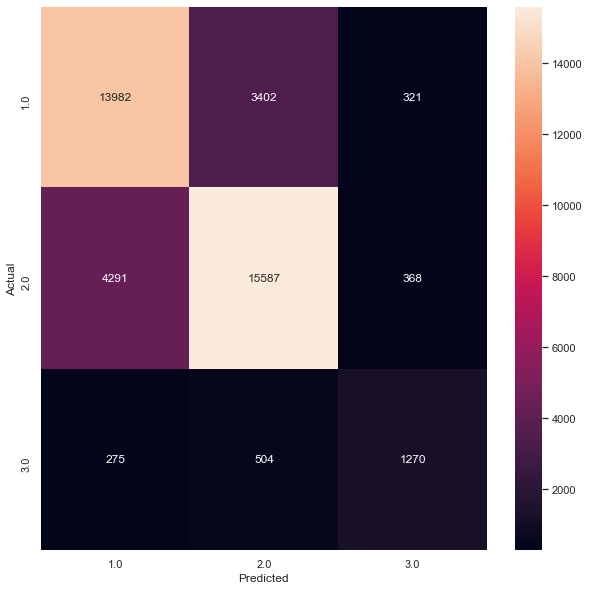

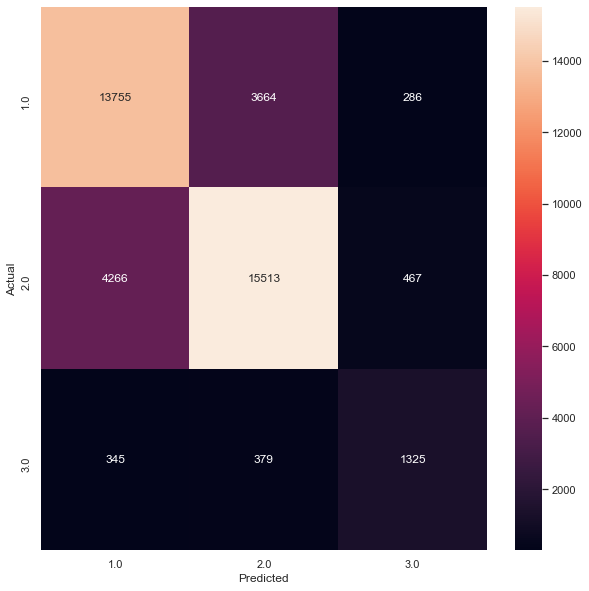

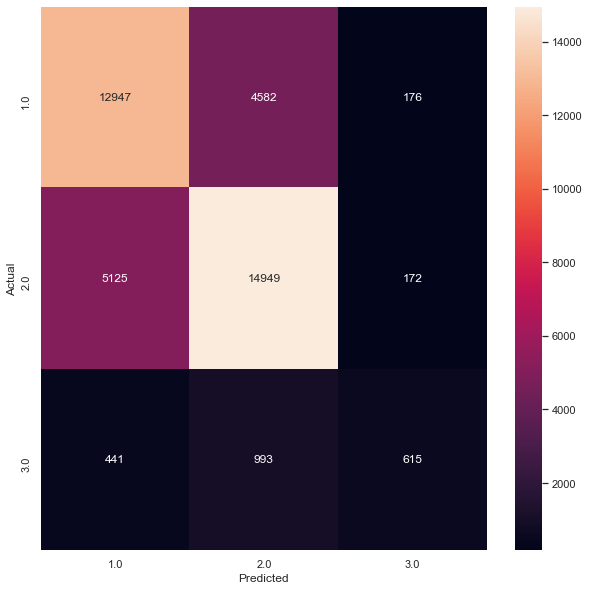

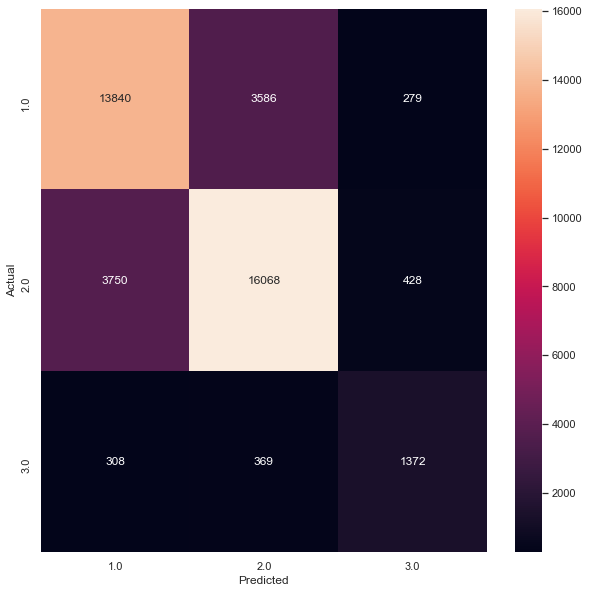

In [5]:
# train and evalutaion phase without SMOTE

wout_SMOTE_scores = []

# this function receives a dataframe and compute the accuracy score, confusion matrix and classification report of different models  
def train_model_without(df):
    X = df.values[:,:-1]
    y = df.values[:,-1]
    y = y.astype('int')
    

    ms = [
    DummyClassifier(strategy='most_frequent'),
    RandomForestClassifier(n_estimators=200, random_state=0),
    RandomForestClassifier(n_estimators=200, class_weight='balanced_subsample'),
    DecisionTreeClassifier(max_depth = 6),
        AdaBoostClassifier(n_estimators=100), 
    LogisticRegression(multi_class='multinomial', solver='lbfgs'),
    MLPClassifier(activation = 'relu', alpha = 0.05, hidden_layer_sizes = (10,30,10), solver = 'adam', max_iter=100)
    ]

    labels = ['1.0', '2.0', '3.0']
    for model in ms:
        y_pred = cross_val_predict(model, X, y, cv=10)
        conf_mat = confusion_matrix(y, y_pred)
        fig, ax = plt.subplots(figsize=(10,10))
        sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=labels, yticklabels=labels)

        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        # plt.show()
        accuracy = accuracy_score(y, y_pred)
        wout_SMOTE_scores.append(accuracy)
        # print(r2_score(y_test,y_pred))
    
        print('Mean Accuracy: %.3f' % (accuracy))
        # print(conf_mat)
        # print(classification_report(y, y_pred))
    

# call the function 
train_model_without(train_df)

In [ ]:
# train and evalutaion phase with SMOTE


with_SMOTE_scores = []

# this function receives a dataframe and compute the accuracy score, confusion matrix and classification report of different models  
def train_model(df):
    X = df.values[:,:-1]
    y = df.values[:,-1]
    y = y.astype('int')
    

    oversample = SVMSMOTE()
    X, y = oversample.fit_resample(X, y)
 

    ms = [
    DummyClassifier(strategy='most_frequent'),
    RandomForestClassifier(n_estimators=200, random_state=0),
    RandomForestClassifier(n_estimators=200, class_weight='balanced_subsample'),
    DecisionTreeClassifier(max_depth = 6),
        AdaBoostClassifier(n_estimators=100), 
    LogisticRegression(multi_class='multinomial', solver='lbfgs'),
    MLPClassifier(activation = 'relu', alpha = 0.05, hidden_layer_sizes = (10,30,10), solver = 'adam', max_iter=100)
    ]

    labels = ['1.0', '2.0', '3.0']
    for model in ms:
        y_pred = cross_val_predict(model, X, y, cv=10)
        conf_mat = confusion_matrix(y, y_pred)
        fig, ax = plt.subplots(figsize=(10,10))
        sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=labels, yticklabels=labels)

        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show()
        accuracy = accuracy_score(y, y_pred)
        with_SMOTE_scores.append(accuracy)
        # print(r2_score(y_test,y_pred))
    
        print('Mean Accuracy: %.3f' % (accuracy))
        print(conf_mat)
        print(classification_report(y, y_pred))
    

# call the function 
train_model(train_df)

In [ ]:
# plotting the classification performances

import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

objects = ('AdaBoost', 'MLPC', 'Logistic Regression', 'Random Forest')
y_pos = np.arange(len(objects))


performance = [wout_SMOTE_scores[4], wout_SMOTE_scores[-1], wout_SMOTE_scores[-2], wout_SMOTE_scores[2]]
per = [with_SMOTE_scores[4], with_SMOTE_scores[-1], with_SMOTE_scores[-2], with_SMOTE_scores[2]]

# create plot
fig, ax = plt.subplots()
index = np.arange(len(objects))
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, performance, bar_width, alpha=opacity, color='b', label='without SMOTE')
rects2 = plt.bar(index + bar_width, per, bar_width, alpha=opacity, color='g', label='with SMOTE')

plt.xticks(index + bar_width, objects)
plt.legend()

plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

In [5]:
# test phase 
import csv

test_steps = pd.read_csv("test_steps_doc2vec50.csv", header=None)

test_data = []

for i in range(len(test_steps)):
    
    c = np.array(test_steps.iloc[i])
    d = np.array(test.iloc[i][['times', 'n_steps', 'n_ingredients']])
    new = np.hstack((c,d))
    test_data.append(new)
    
test_df = pd.DataFrame(test_data)


# this function predicts the class labels of test datasets given the train dataset and the model 
def predict(test_df, model, train_df):
    
    X_train = train_df.values[:,:-1]
    y_train = train_df.values[:,-1]
    X_test = test_df.values[:,:]
    
    oversample = SVMSMOTE()
    X_train, y_train = oversample.fit_resample(X_train, y_train)
    
   
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return y_pred
    
# write the output files

m = [RandomForestClassifier(n_estimators=200, class_weight='balanced_subsample'),
    DecisionTreeClassifier(max_depth = 6), 
    LogisticRegression(multi_class='multinomial', solver='lbfgs'),
    MLPClassifier(activation = 'relu', alpha = 0.05, hidden_layer_sizes = (10,30,10), solver = 'adam', max_iter=100)]


y_pred = predict(test_df, m[0],train_df)

# rows for the csv files
rows = []
for i in range(len(test_df)):
    rows.append([i+1, y_pred[i]])
    
with open('random_forest.csv', mode='w') as f:
    writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(['id', 'duration_label'])
    writer.writerows(rows)
    
y_pred = predict(test_df, m[1],train_df)

# rows for the csv files
rows = []
for i in range(len(test_df)):
    rows.append([i+1, y_pred[i]])
    
with open('decision_tree.csv', mode='w') as f:
    writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(['id', 'duration_label'])
    writer.writerows(rows)
    

y_pred = predict(test_df, m[2],train_df)

# rows for the csv files
rows = []
for i in range(len(test_df)):
    rows.append([i+1, y_pred[i]])
    
with open('LogisticRegre.csv', mode='w') as f:
    writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(['id', 'duration_label'])
    writer.writerows(rows)
    

y_pred = predict(test_df, m[3],train_df)

# rows for the csv files
rows = []
for i in range(len(test_df)):
    rows.append([i+1, y_pred[i]])
    
with open('mlpc.csv', mode='w') as f:
    writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(['id', 'duration_label'])
    writer.writerows(rows)
    

    
